In [1]:
import warnings
warnings.filterwarnings('ignore')

from astropy.table import Table, hstack, vstack, join
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from spectral_cube import SpectralCube
import scipy 
from reproject import reproject_interp

import astropy.constants as ac
import astropy.units as au
from astropy import stats
from astrodendro.analysis import PPStatistic
from astrodendro import Dendrogram, pp_catalog
from astropy.wcs import WCS
from collections import Counter

from astropy.io import fits
import matplotlib as mpl
import pyregion
import aplpy
import math
import os
import pickle
from tqdm.auto import tqdm 

from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

from mods import *

In [2]:
def get_trunkindexmap(dendro):
    """Get index map of trunk idx"""
    
    # print('[INFO] Getting indexmap of dendrogram trunks')
    mask = 0
    for i in range(len(dendro.trunk)):

        trunk = dendro.trunk[i]
        idx = trunk.idx
        mask = trunk.get_mask()
        mask = mask*1.0
        mask[mask==0] = np.nan
        mask[mask==1] = idx

        if i==0: 
            indexmap_trunk = mask
        else: 
            indexmap_trunk = np.nanmean(np.array([indexmap_trunk,mask]), axis=0)  

    indexmap_trunk[np.isnan(indexmap_trunk)] = -1
    
    return(indexmap_trunk)


def get_circrad(data, pixsize):
    """Returns circularised radius in arcsec"""
    area = np.nansum((data > -1)*1)
    radius = (area/np.pi)**0.5
    radius = radius * pixsize.to('arcsec')
    return(radius)

In [3]:
def get_scaling(data):
    data = (data-np.nanmin(data))/(np.nanmax(data)-np.nanmin(data))
    return(data)

def make_plot(hdu, props, indexmap_trunk_hdu, indexmap_trunk_close_hdu, regions, i, outdir='', mask_muse=None):

    """Make plot"""
    
    ra = regions['ra'][i].value
    dec = regions['dec'][i].value
    width = regions['width'][i].value
    height = regions['height'][i].value
    radius = max([width,height])
    
    center = [ra, dec, radius, radius]

    fig = plt.figure(figsize=(10,10))
    ax = ['']*3
    
    hdu_ = hdu.copy()
    hdu_.data = get_scaling(hdu_.data)
    for i in range(3):
        
        ax[i] = aplpy.FITSFigure(hdu_, figure=fig, subplot=(1,3,i+1))
        minmax = np.nanpercentile(hdu_.data, [0.1,99.99])
        ax[i].show_colorscale(cmap='gist_gray_r', vmin=minmax[0], vmax=minmax[-1], stretch='log')

        ax[i].recenter(center[0], center[1], width=center[2], height=center[3])

        ra_struc = ax[i].pixel2world(props['x_cen'], props['y_cen'])[0][0]
        dec_struc = ax[i].pixel2world(props['x_cen'], props['y_cen'])[1][0]   
    
        ax[i].tick_labels.hide()
        ax[i].axis_labels.hide()
        ax[i].ticks.set_color('black')
        ax[i].set_nan_color('white')

    ax[0].show_contour(indexmap_trunk_hdu, colors='C1', levels=[-1], linestyles='-')
    ax[1].show_contour(indexmap_trunk_close_hdu, colors='C1', levels=[-1], linestyles='-')

    ax[0].show_ellipses(xw=ra_struc, yw=dec_struc, 
             width=props['radius_trunk'].quantity.to('deg').value[0]*2,
             height=props['radius_trunk'].quantity.to('deg').value[0]*2,
             linestyle='--', edgecolor='C1', linewidth=2)

    ax[1].show_ellipses(xw=ra_struc, yw=dec_struc, 
             width=props['radius_trunkclose'].quantity.to('deg').value[0]*2,
             height=props['radius_trunkclose'].quantity.to('deg').value[0]*2,
             linestyle='--', edgecolor='C1', linewidth=2)
    
    #Ellipses
    ax[2].show_ellipses(xw=ra_struc, yw=dec_struc, 
                     width=props['major_sigma'].quantity.to('deg').value[0]*2,#sigma
                     height=props['minor_sigma'].quantity.to('deg').value[0]*2,#sigma
                     angle=props['position_angle'].quantity.to('deg').value[0],
                     linestyle='-', edgecolor='C3', linewidth=2)

    ax[2].show_ellipses(xw=ra_struc, yw=dec_struc, 
                     width=props['major_sigma'].quantity.to('deg').value[0]*4.292,#FWTM
                     height=props['minor_sigma'].quantity.to('deg').value[0]*4.292,#FWTM
                     angle=props['position_angle'].quantity.to('deg').value[0],
                     linestyle='--', edgecolor='C3', linewidth=2)  

    #Mean of ellipses
    ax[2].show_ellipses(xw=ra_struc, yw=dec_struc, 
                     width=props['mean_sigma'].quantity.to('deg').value[0]*2,#sigma
                     height=props['mean_sigma'].quantity.to('deg').value[0]*2,#sigma
                     linestyle=':', edgecolor='C3', linewidth=2)

    ax[2].show_ellipses(xw=ra_struc, yw=dec_struc, 
                     width=props['mean_sigma'].quantity.to('deg').value[0]*4.292,#FWTM
                     height=props['mean_sigma'].quantity.to('deg').value[0]*4.292,#FWTM
                     linestyle=':', edgecolor='C3', linewidth=2) 

    if mask_muse!=None:
        for i in range(3):
            ax[i].show_contour(mask_muse, colors='black', levels=[1], linestyles='-')
        fig.get_axes()[0].plot([0,0],[0,0],ls='-',c='black',label='MUSE mask')
        
    ax[0].add_label(0.5,0.95,'structure contour',relative=True)
    ax[1].add_label(0.5,0.95,'structure contour with closing',relative=True)
    ax[2].add_label(0.5,0.95,'structure 2nd order moments',relative=True)

    fig.get_axes()[0].plot([0,0],[0,0],ls='-',c='C1',label='structure')
    fig.get_axes()[0].plot([0,0],[0,0],ls='--',c='C1',label='circular radius')

    fig.get_axes()[1].plot([0,0],[0,0],ls='-',c='C1',label='structure')
    fig.get_axes()[1].plot([0,0],[0,0],ls='--',c='C1',label='circular radius')

    fig.get_axes()[2].plot([0,0],[0,0],ls='-',c='C3',label='sigma')
    fig.get_axes()[2].plot([0,0],[0,0],ls='--',c='C3',label='FHTM')

    fig.get_axes()[2].plot([0,0],[0,0],ls=':',c='C3',label='sigma mean')
    fig.get_axes()[2].plot([0,0],[0,0],ls=':',c='C3',label='FHTM mean')


    fig.get_axes()[0].legend(loc='lower left')
    fig.get_axes()[1].legend(loc='lower left')
    fig.get_axes()[2].legend(loc='lower left')
    
    fig.tight_layout()
    fig.savefig('%s/dendro_regionoutput_%i.pdf' %(outdir, regionID), bbox_inches='tight', dpi=300)
    plt.close('all')
    
    return()

def make_plot_sigmacomp(hdu, props, indexmap_trunk_hdu, regions, i, outdir='', mask_muse=None):

    """Make plot"""
    
    ra = regions['ra'][i].value
    dec = regions['dec'][i].value
    width = regions['width'][i].value
    height = regions['height'][i].value
    radius = max([width,height])
    
    center = [ra, dec, radius, radius]

    fig = plt.figure(figsize=(10,10))
    ax = ['']*3
    
    hdu_ = hdu.copy()
    hdu_.data = get_scaling(hdu_.data)
    
    for i in range(3):
                
        ax[i] = aplpy.FITSFigure(hdu_, figure=fig, subplot=(1,3,i+1))
        minmax = np.nanpercentile(hdu_.data, [0.1,99.99])
        ax[i].show_colorscale(cmap='gist_gray_r', vmin=minmax[0], vmax=minmax[-1], stretch='log')
        ax[i].recenter(center[0], center[1], width=center[2], height=center[3])
        ax[i].tick_labels.hide()
        ax[i].axis_labels.hide()
        ax[i].ticks.set_color('black')
        ax[i].set_nan_color('white')

        if props[i]==None: 
            ax[i].add_label(0.5,0.5,'NO FIT',c='r',relative=True)
            continue
        
        ra_struc = ax[i].pixel2world(props[i]['x_cen'], props[i]['y_cen'])[0][0]
        dec_struc = ax[i].pixel2world(props[i]['x_cen'], props[i]['y_cen'])[1][0]   
    
        ax[i].show_contour(indexmap_trunk_hdu[i], colors='C1', levels=[-1], linestyles='-')
    
        ax[i].show_ellipses(xw=ra_struc, yw=dec_struc, 
                 width=props[i]['radius_trunk'].quantity.to('deg').value[0]*2,
                 height=props[i]['radius_trunk'].quantity.to('deg').value[0]*2,
                 linestyle='--', edgecolor='C1', linewidth=2)
    
        #Ellipses
        ax[i].show_ellipses(xw=ra_struc, yw=dec_struc, 
                         width=props[i]['major_sigma'].quantity.to('deg').value[0]*2,#sigma
                         height=props[i]['minor_sigma'].quantity.to('deg').value[0]*2,#sigma
                         angle=props[i]['position_angle'].quantity.to('deg').value[0],
                         linestyle='-', edgecolor='C3', linewidth=2)

        ax[i].show_ellipses(xw=ra_struc, yw=dec_struc, 
                         width=props[i]['major_sigma'].quantity.to('deg').value[0]*4.292,#FWTM
                         height=props[i]['minor_sigma'].quantity.to('deg').value[0]*4.292,#FWTM
                         angle=props[i]['position_angle'].quantity.to('deg').value[0],
                         linestyle='--', edgecolor='C3', linewidth=2)  

        #Mean of ellipses
        ax[i].show_ellipses(xw=ra_struc, yw=dec_struc, 
                         width=props[i]['mean_sigma'].quantity.to('deg').value[0]*2,#sigma
                         height=props[i]['mean_sigma'].quantity.to('deg').value[0]*2,#sigma
                         linestyle=':', edgecolor='C3', linewidth=2)

        ax[i].show_ellipses(xw=ra_struc, yw=dec_struc, 
                         width=props[i]['mean_sigma'].quantity.to('deg').value[0]*4.292,#FWTM
                         height=props[i]['mean_sigma'].quantity.to('deg').value[0]*4.292,#FWTM
                         linestyle=':', edgecolor='C3', linewidth=2) 

    if mask_muse!=None:
        for i in range(3):
            ax[i].show_contour(mask_muse, colors='black', levels=[1], linestyles='-')
            
        fig.get_axes()[0].plot([0,0],[0,0],ls='-',c='black',label='MUSE mask')
        
    ax[0].add_label(0.02,0.95,'min_value_sig=2sigma',relative=True,ha='left')
    ax[1].add_label(0.02,0.95,'min_value_sig=3sigma',relative=True,ha='left')
    ax[2].add_label(0.02,0.95,'min_value_sig=4sigma',relative=True,ha='left')
    
    fig.tight_layout()
    fig.savefig('%s/dendro_regionoutput_%i.pdf' %(outdir, regionID), bbox_inches='tight', dpi=300)
    plt.close('all')
    
    return()

In [4]:
# Get Galaxy properties
galaxy = 'ngc0628'
sampletable = Table.read("./../../../data/sampletable/phangs_sample_table_v1p6.fits")

mask = sampletable['name'] == galaxy
sampletable = sampletable[mask]

dist = sampletable['dist'].quantity[0]
pcperarcsec = dist.to('pc').value/206265
print('pcperarcsec ---> %0.001f' %pcperarcsec)

pcperarcsec ---> 47.7


In [5]:
# Get MUSE data for galaxy
muscat_file = '/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/physprops/master_notmasked.fits' #MUSE catalogue with properties

muscat_table = Table.read(muscat_file)
muscat_table = muscat_table[muscat_table['gal_name'] == galaxy.swapcase()]
muscat_table.rename_column('region_ID', 'muscat_id')

# Get MUSE REFITTED data for galaxy
muscat_newfits_file = '/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/raw/Nebulae_catalogue_v2_refitNII_refitTe.fits' #MUSE catalogue with properties

muscat_newfits_table = Table.read(muscat_newfits_file)
muscat_newfits_table = muscat_newfits_table[muscat_newfits_table['GAL_NAME'] == galaxy.swapcase()]
muscat_newfits_table.rename_column('REGION_ID', 'muscat_id')
muscat_newfits_table = muscat_newfits_table['muscat_id', 'T_N2_REFIT']
muscat_table = join(muscat_table, muscat_newfits_table, 'muscat_id')

In [6]:
hdus = load_pickle('../../analysis/catalogue/hdus_sample_v2.pickel')

[INFO] Load ../../analysis/catalogue/hdus_sample_v2.pickel


In [7]:
def get_regions(regions_file, hdu):
    
    regions = pyregion.open(regions_file).as_imagecoord(hdu.header)
    n = len(regions)
    
    ra = np.empty(n)*np.nan*au.deg
    dec = np.empty(n)*np.nan*au.deg
    width = np.empty(n)*np.nan*au.deg
    height = np.empty(n)*np.nan*au.deg
    position = ['']*n
    
    for i, region in enumerate(regions):

        ra[i] = float(region.params[0].text)*au.deg
        dec[i] = float(region.params[1].text)*au.deg
        width[i] = region.params[2].degree*au.deg
        height[i] = region.params[3].degree*au.deg
        
    position = SkyCoord(ra=ra, dec=dec, frame='icrs')

    return({'ra':ra, 'dec':dec, 'width':width, 'height':height, 'position': position})

regions_file = './../../analysis/catalogue/sample_v2.reg'
regions = get_regions(regions_file, hdus['hst01_hdus'][0])

In [8]:
def get_maskeddata(muscat_hdu, hst06_hdu): 
    
    #load
    # muscat_hdu = hdus['muscat_hdus'][regionID]
    # hst06_hdu = hdus['hst06_hdus'][regionID]
    
    hst06_masked_hdu = hst06_hdu.copy() #only ID in mask
    hst06_maskedall_hdu = hst06_hdu.copy() #all MUSE regions out of mask - for noise measure
    
    #get mask 
    shape = muscat_hdu.data.shape
    muscat_id = muscat_hdu.data[int(shape[0]/2),int(shape[0]/2)]
    
    mask1 = muscat_hdu.data!=muscat_id #if catalouge is not ID
    mask2 = np.isnan(muscat_hdu.data) #if catalouge is not a number
    
    muscat_hdu1 = muscat_hdu.copy()
    muscat_hdu2 = muscat_hdu.copy()
    
    muscat_hdu1.data[mask1] = np.nan
    muscat_hdu2.data[mask2] = 1
    muscat_hdu2.data[~mask2] = np.nan

    #regrid
    data1 = reproject_interp(muscat_hdu1, hst06_hdu.header, return_footprint=False, order='nearest-neighbor')
    data2 = reproject_interp(muscat_hdu2, hst06_hdu.header, return_footprint=False, order='nearest-neighbor')

    # muscat_regrid_hdu = fits.PrimaryHDU(data, hst06_hdu.header)

    #mask 
    hst06_masked_hdu.data[np.isnan(data1)] = np.nan
    hst06_maskedall_hdu.data[np.isnan(data2)] = np.nan
    
    return(hst06_masked_hdu, hst06_maskedall_hdu, muscat_id)

In [9]:
def get_dedro(hdu, hdu_outmask, hdu_nomask, min_npix=9, min_value_sig=3, min_delta_sig=3):

    # replace to basic names
    hdu = hst06_masked_hdu
    wcs = WCS(hdu.header)
    header = hdu.header
    data = hdu.data
    data_nomask = hst06_hdu.data
    
    data_outmask = hdu_outmask.data

    # get stats for dendro
    # mean and std calculated on the non-masked data
    std = stats.mad_std(data_outmask, ignore_nan=True)              #get noise
    std = stats.mad_std(data_outmask[data_outmask<10*std], ignore_nan=True)  #get noise below threshold
    mean = np.nanmean(data_outmask[data_nomask<10*std])                     #get mean below threshold 
    data = data-mean                                        #minus mean to level on 0
    data_nomask = data_nomask-mean   
    std = stats.mad_std(data_outmask[data_outmask<5*std], ignore_nan=True)  #get noise below threshold again

    pixsize = np.array([-1*hst06_hdu.header['CDELT1'], hst06_hdu.header['CDELT2']]).mean() *au.degree
    bmaj = bmin = 0.05 *au.arcsec #dummy 

    min_value = std*min_value_sig #Minimum value within structure
    min_delta = std*min_delta_sig #Minimum values between levels within structure (sort of)


    """Running the dendrogram"""

    dendro = Dendrogram.compute(data,
                                min_delta=min_delta,
                                min_value=min_value,
                                min_npix=min_npix,
                                wcs=wcs)


    """Provide some metadata for table output"""

    metadata = {}
    metadata['data_unit'] = au.Jy / au.beam #Dummy unit
    metadata['spatial_scale'] =  pixsize.to('arcsec')
    metadata['beam_major'] =  bmaj.to('arcsec')
    metadata['beam_minor'] =  bmin.to('arcsec')

    
    # props = pp_catalog(dendro, metadata, verbose=False) #Get table
    
    if len(np.unique(dendro.index_map))!=1: 
        props = pp_catalog(dendro, metadata, verbose=False) #Get table
    else: 
        return([None]*4)

    indexmap = dendro.index_map #Get index map
    indexmap_hdu = fits.PrimaryHDU(indexmap, header)
    indexmap_hdu.data = np.array(indexmap_hdu.data, dtype=float)
    indexmap_hdu.data[indexmap_hdu.data==-1] = np.nan

    indexmap_trunk = get_trunkindexmap(dendro)
    indexmap_trunk_hdu = fits.PrimaryHDU(indexmap_trunk, header)
    indexmap_trunk_hdu.data = np.array(indexmap_trunk_hdu.data, dtype=float)

    props_trunk = pp_catalog(dendro.trunk, metadata, verbose=False) #Get table
    props_trunk_ = pp_catalog(dendro.trunk, metadata, verbose=False) #Get table


    
    
    """Get the ID of the structure"""

    ###
    # Get brightest
    arg = np.argmax(props_trunk['flux'])
    midpix_id = props_trunk['_idx'][arg]
    
    ###
    
    #Remove all other strucutres from catalouge
    indexmap_trunk_hdu.data[indexmap_trunk_hdu.data!=midpix_id] = -1
    props = props[props['_idx'] == midpix_id]


    
    
    
    """Get single trunk index map"""

    idx = np.unique(indexmap_trunk_hdu.data[indexmap_trunk_hdu.data != -1])
    mask = indexmap_trunk_hdu.data != -1
    mask1 = scipy.ndimage.binary_closing(mask, iterations=10)*1
    mask1[mask1!=1.0] = -1.
    mask1[mask1==1.0] = idx
    indexmap_trunk_close = np.copy(mask1)
    indexmap_trunk_close_hdu = fits.PrimaryHDU(indexmap_trunk_close, indexmap_trunk_hdu.header)

    radius_trunk = get_circrad(indexmap_trunk_hdu.data, pixsize)
    radius_trunkclose = get_circrad(indexmap_trunk_close_hdu.data, pixsize)


    """Add properties to table"""

    props['id'] = regionID
    props['radius_trunk'] = radius_trunk
    props['radius_trunkclose'] = radius_trunkclose
    props['major_fwtm'] = props['major_sigma']*4.292
    props['minor_fwtm'] = props['minor_sigma']*4.292
    props['mean_fwtm'] = np.nanmean([props['major_fwtm'], props['minor_fwtm']])*props['major_fwtm'].unit
    props['mean_hwtm'] = props['mean_fwtm']/2.
    
    props['min_npix'] = min_npix
    props['min_value_sig'] = min_value_sig
    props['min_delta_sig'] = min_delta_sig
    
    #convert to parcsec
    props['radius_trunk_pc'] = props['radius_trunk'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['radius_trunkclose_pc'] = props['radius_trunkclose'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['major_fwtm_pc'] = props['major_fwtm'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['minor_fwtm_pc'] = props['minor_fwtm'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['mean_fwtm_pc'] = props['mean_fwtm'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['mean_hwtm_pc'] = props['mean_fwtm_pc']/2.

    ax = aplpy.FITSFigure(hdu)
    ra_struc = ax.pixel2world(props['x_cen'], props['y_cen'])[0][0]
    dec_struc = ax.pixel2world(props['x_cen'], props['y_cen'])[1][0]   
    plt.close('all')
    
    props['ra_cent'] = ra_struc * au.deg
    props['dec_cent'] = dec_struc * au.deg
    props.rename_column('radius', 'mean_sigma')
    props['mean_sigma_pc'] = props['mean_sigma'].quantity[0].to('arcsec').value * pcperarcsec * au.pc

    flux = np.nansum(hdu.data[indexmap_trunk_close_hdu.data!=-1])
    props['flux'] = flux

    return(dendro, props, indexmap_trunk_hdu, indexmap_trunk_close_hdu)

  0%|          | 0/215 [00:00<?, ?it/s]

TypeError: list indices must be integers or slices, not str

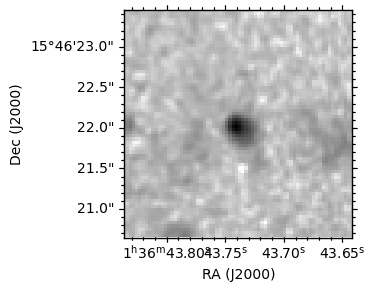

In [14]:
min_value_sig = [2,3,4]
props_all = {'2sig':'', 
             '3sig':'',
             '4sig':''}

for regionID in tqdm(range(len(regions['ra']))): 
    
    # if regionID>2:
    #     continue
    
    #load
    muscat_hdu = hdus['muscat_hdus'][regionID]
    hst06_hdu = hdus['hst06_hdus'][regionID].copy()

    #smooth
    kernel = Gaussian2DKernel(x_stddev=0.5)
    hst06_hdu.data = convolve(hst06_hdu.data, kernel)
    
    #mask
    hst06_masked_hdu, hst06_maskedall_hdu, muscat_id = get_maskeddata(muscat_hdu, hst06_hdu) #Get masked data 
    mask_muse = fits.PrimaryHDU(~np.isnan(hst06_masked_hdu.data)*1, hst06_masked_hdu.header)
    
    #dendro
    props, indexmap_trunk_hdu = ['']*3, ['']*3
    for i in range(3):
        output = get_dedro(hst06_masked_hdu,
                      hst06_maskedall_hdu, 
                      hst06_hdu, min_npix=9, 
                      min_value_sig=min_value_sig[i], 
                      min_delta_sig=3)

        dendro, props[i], indexmap_trunk_hdu[i], indexmap_trunk_close_hdu = output
        
        props[i]['muscat_id'] = muscat_id

    make_plot(hst06_hdu, props, indexmap_trunk_hdu, indexmap_trunk_close_hdu, regions, regionID, './../../analysis/dendro/indexmaps_figs/', mask_muse)
    make_plot_sigmacomp(hst06_hdu, props, indexmap_trunk_hdu, regions, regionID, './../../analysis/dendro/indexmaps_figs_sigmacomp/', mask_muse)
    
    # Add to table and save
    if regionID == 0: 
        props_all['2sig'] = props[0].copy()
        props_all['3sig'] = props[1].copy()
        props_all['4sig'] = props[2].copy()
        indexmap_trunk_hdus = [indexmap_trunk_hdu[1].copy()]
        
    else: 
        props_all['2sig'].add_row(props[0][0])
        props_all['3sig'].add_row(props[1][0])
        props_all['4sig'].add_row(props[2][0])
        indexmap_trunk_hdus = indexmap_trunk_hdus+[indexmap_trunk_hdu[1].copy()]
        
hdus['indexmap_trunk_hdus'] = indexmap_trunk_hdus #only taking the 3sigma

In [11]:
# Add in MUSE informaiton

props_all['2sig'] = join(props_all['2sig'], muscat_table, 'muscat_id')
props_all['3sig'] = join(props_all['3sig'], muscat_table, 'muscat_id')
props_all['4sig'] = join(props_all['4sig'], muscat_table, 'muscat_id')

In [12]:
# save_pickle(props_all, '../../analysis/dendro/props_all/props_all_1.pickel') 
# props_all['2sig'].write( '../../analysis/dendro/props_all/props_all2sig_1.fits', overwrite=True)
# props_all['3sig'].write( '../../analysis/dendro/props_all/props_all3sig_1.fits', overwrite=True)
# props_all['4sig'].write( '../../analysis/dendro/props_all/props_all4sig_1.fits', overwrite=True)
# save_pickle(hdus, '../../analysis/catalogue/hdus_sample_withdendro.pickel') 